# Train Classifier For News Classification
> ## * Doc2Vec

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os
from glob import glob 

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import doc2vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,  accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import xgboost as xgb

import matplotlib.pyplot as plt

import seaborn as sns 

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
%matplotlib inline

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4280749659225018391
]


In [3]:
def Make_Roc_Curve(x, y, model1, model2, model3, model4):
    print ('Logistic Regression')
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    print ('Random Forest')
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    print ('Kernel SVM')
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    print ('XGBoost')
    import xgboost as xgb
    fpr4, tpr4, thresholds4 = roc_curve(y, model4.predict(xgb.DMatrix(x)))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.plot(fpr4, tpr4, label='XGBoost')
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [4]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [5]:
def Get_Infer_Vector(docs, model):
    return [model.infer_vector(doc.words) for doc in tqdm(docs)]

In [6]:
def ConfusionMatrix_To_Heatmap(train_x, train_y, test_x, test_y, classifier, labelEncoder):
    from sklearn.metrics import confusion_matrix
    unique_y = list(set(train_y))
    train_confusion = confusion_matrix(train_y, classifier.predict(train_x))
    train_confusion = pd.DataFrame(train_confusion, 
                                  columns = labelEncoder.inverse_transform(unique_y),
                                  index = labelEncoder.inverse_transform(unique_y))
    test_confusion = confusion_matrix(test_y, classifier.predict(test_x))
    test_confusion = pd.DataFrame(test_confusion, 
                                  columns = labelEncoder.inverse_transform(unique_y),
                                  index = labelEncoder.inverse_transform(unique_y))
    fig = plt.figure(figsize=(16,6))
    fig.text(0.5, 0.04, 'Predicted', ha='center')
    fig.text(0.04, 0.5, 'Actual', va='center', rotation='vertical')
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.title('train data Confusion matrix')
    plt.rcParams['font.family'] = 'NanumBarunGothicOTF'
    sns.heatmap(train_confusion, annot = True, fmt = 'g', ax = ax1)
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('test data Confusion matrix')
    plt.rcParams['font.family'] = 'NanumBarunGothicOTF'
    sns.heatmap(test_confusion, annot = True, fmt = 'g', ax = ax2)

In [7]:
cores = int(multiprocessing.cpu_count() )
print (cores)

4


## Stopwords

In [8]:
stopwords = open('./data/stopwordsList.txt',encoding='utf-8').readlines()
stopwords = list(map(lambda x: x.strip(), stopwords))

## Documnet Labeling

In [9]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags category')

> * words : 기사에서 나온 단어들 or keywords
> * tags : 문서 tag
> * classes : category
>> 기사분류가 daum보다 naver에서 더 세분화되어 있기 때문에 네이버의 category 분류를 이용하기로 함

## Category 

In [10]:
if os.path.isfile('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_doc2vec_news_classification.pickled'):
    le = pickle.load(open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_doc2vec_news_classification.pickled','rb'))
else:
    le = LabelEncoder()
    le.fit(naverData['category'])
    pickle.dump(le, open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_doc2vec_news_classification.pickled','wb'))
print (le.classes_)

['IT/과학' '경제' '사회' '생활/문화' '세계' '스포츠' '연예' '정치']


In [11]:
if sys.platform =='darwin':
    loadModelPath = './news_model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/news_model/'
saveTrainPath = './data/pre_data/news_train_test_Data2/'
saveClassifierPath = './data/pre_data/news_classifier/'

## Twitter

### Load Model

In [12]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model')

### Train dataset & test dataset

In [13]:
trainName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_train_for_news_classification_by_ct.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_test_for_news_classification_by_ct.pickled'

In [14]:
train = pickle.load(open(trainName, 'rb'))
test = pickle.load(open(testName, 'rb'))

#### train dataset

In [15]:
taggerName = 'ct'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_category_y_ct_for_news_classification'):
    train_category_y = [doc.category for doc in tqdm(train)]
    
    pickle.dump(train_category_y, open(saveTrainPath+'train_category_y_ct_for_news_classification','wb'))
    del train_category_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_ct_for_news_classification'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_ct_for_news_classification','wb'))
    del train_tags_y

if 'train' in locals():
    del train

#### test dataset

In [16]:
taggerName = 'ct'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_category_y_ct_for_news_classification'):
    test_category_y = [doc.category for doc in tqdm(test)]
    
    pickle.dump(test_category_y, open(saveTrainPath+'test_category_y_ct_for_news_classification','wb'))
    del test_category_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_ct_for_news_classification'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_ct_for_news_classification','wb'))
    del test_tags_y

if 'test' in locals():
    del test

### model1

In [17]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-ct'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_ct_for_news_classification', 'rb'))
train_y2 = [y[0] for y in tqdm(train_y)]
len(train_y), len(train_x_by_m1)

100%|██████████| 12852/12852 [00:00<00:00, 1808899.16it/s]


(12852, 12852)

In [18]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_ct_for_news_classification', 'rb'))
test_y2 = [y[0] for y in tqdm(test_y)]
len(test_y), len(test_x_by_m1)

100%|██████████| 2268/2268 [00:00<00:00, 780944.21it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [19]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.7945326278659612
classification report
             precision    recall  f1-score   support

          0       0.85      0.80      0.83       276
          1       0.78      0.73      0.76       282
          2       0.72      0.67      0.70       309
          3       0.76      0.73      0.75       296
          4       0.75      0.75      0.75       269
          5       0.93      0.98      0.95       291
          6       0.76      0.93      0.84       271
          7       0.80      0.76      0.78       274

avg / total       0.79      0.79      0.79      2268

CPU times: user 14.7 s, sys: 121 ms, total: 14.8 s
Wall time: 14.9 s


In [20]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

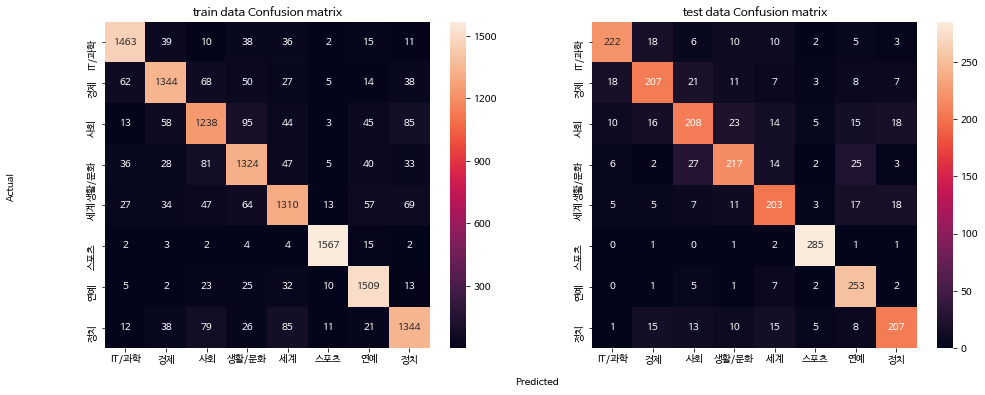

In [21]:
ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [22]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.6825396825396826
classification report
             precision    recall  f1-score   support

          0       0.74      0.73      0.73       276
          1       0.62      0.66      0.64       282
          2       0.57      0.56      0.57       309
          3       0.71      0.53      0.60       296
          4       0.59      0.63      0.61       269
          5       0.83      0.96      0.89       291
          6       0.73      0.83      0.78       271
          7       0.66      0.58      0.61       274

avg / total       0.68      0.68      0.68      2268

CPU times: user 43.2 s, sys: 268 ms, to

In [23]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

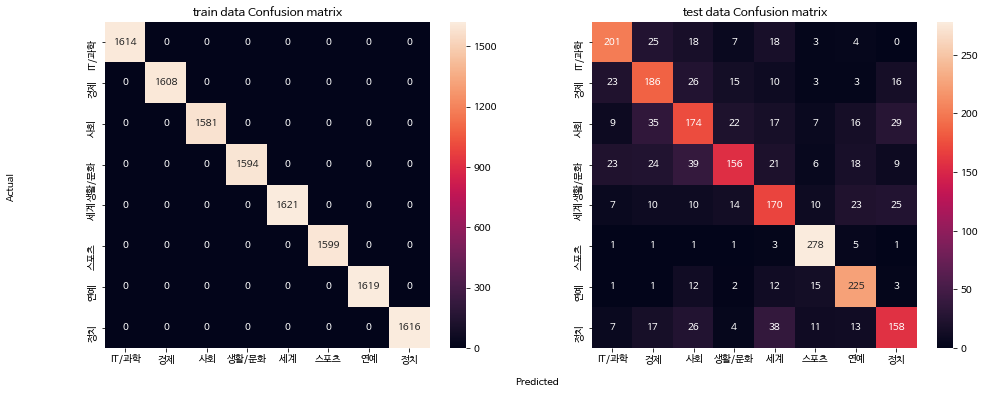

In [24]:
ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [25]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.8258377425044092
classification report
             precision    recall  f1-score   support

          0       0.88      0.83      0.85       276
          1       0.81      0.77      0.79       282
          2       0.69      0.79      0.73       309
          3       0.80      0.77      0.79       296
          4       0.78      0.80      0.79       269
          5       0.97      0.97      0.97       291
          6       0.84      0.94      0.89       271
          7       0.89      0.74      0.81       274

avg / total       0.83      0.83      0.83      2268

CPU times: user 1min 23s, sys: 236 ms, total: 1min 23s
Wall time: 1min 24s


In [26]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

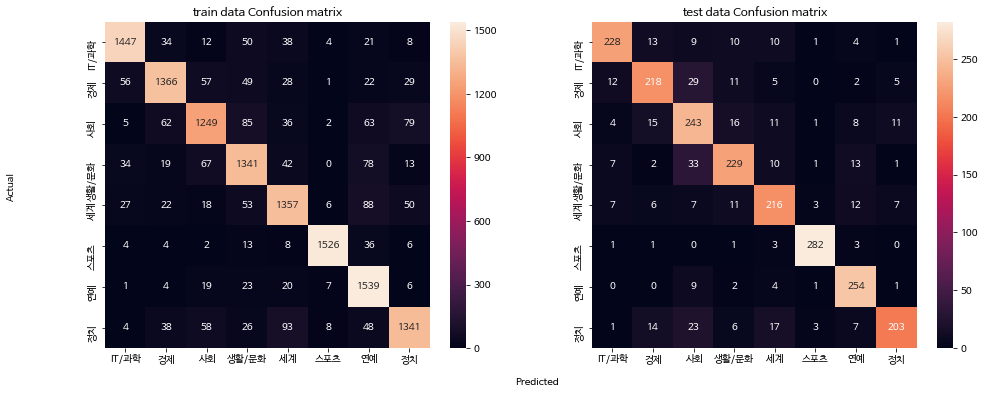

In [27]:
ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier3, le)

#### XGBoost 

In [28]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 668682.80it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 850333.55it/s]

CPU times: user 107 ms, sys: 25.7 ms, total: 133 ms
Wall time: 130 ms


In [29]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 27.1 ms, sys: 9.25 ms, total: 36.4 ms
Wall time: 34 ms


In [30]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m1_name)

[0]	train-mlogloss:1.93838	eval-mlogloss:1.96736
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.81692	eval-mlogloss:1.87101
[2]	train-mlogloss:1.71326	eval-mlogloss:1.7917
[3]	train-mlogloss:1.62255	eval-mlogloss:1.71806
[4]	train-mlogloss:1.53994	eval-mlogloss:1.65501
[5]	train-mlogloss:1.46628	eval-mlogloss:1.59966
[6]	train-mlogloss:1.40026	eval-mlogloss:1.55218
[7]	train-mlogloss:1.33896	eval-mlogloss:1.50758
[8]	train-mlogloss:1.28298	eval-mlogloss:1.46489
[9]	train-mlogloss:1.2303	eval-mlogloss:1.42428
[10]	train-mlogloss:1.18148	eval-mlogloss:1.38581
[11]	train-mlogloss:1.13609	eval-mlogloss:1.35052
[12]	train-mlogloss:1.09232	eval-mlogloss:1.32001
[13]	train-mlogloss:1.05243	eval-mlogloss:1.29005
[14]	train-mlogloss:1.01541	eval-mlogloss:1.26231
[15]	train-mlogloss:0.980086	eval-mlogloss:1.23779
[16]	train-mlogloss:0.94628	eval-mlogloss:1.21102
[17]	train

[156]	train-mlogloss:0.03038	eval-mlogloss:0.591497
[157]	train-mlogloss:0.029762	eval-mlogloss:0.590602
[158]	train-mlogloss:0.029165	eval-mlogloss:0.590834
[159]	train-mlogloss:0.028609	eval-mlogloss:0.59
[160]	train-mlogloss:0.028081	eval-mlogloss:0.589469
[161]	train-mlogloss:0.027617	eval-mlogloss:0.588989
[162]	train-mlogloss:0.027107	eval-mlogloss:0.588444
[163]	train-mlogloss:0.026635	eval-mlogloss:0.587742
[164]	train-mlogloss:0.026166	eval-mlogloss:0.587351
[165]	train-mlogloss:0.025731	eval-mlogloss:0.58692
[166]	train-mlogloss:0.025244	eval-mlogloss:0.586559
[167]	train-mlogloss:0.024779	eval-mlogloss:0.585939
[168]	train-mlogloss:0.024348	eval-mlogloss:0.585542
[169]	train-mlogloss:0.023926	eval-mlogloss:0.585678
[170]	train-mlogloss:0.023474	eval-mlogloss:0.585364
[171]	train-mlogloss:0.023055	eval-mlogloss:0.584406
[172]	train-mlogloss:0.022684	eval-mlogloss:0.583294
[173]	train-mlogloss:0.022291	eval-mlogloss:0.582993
[174]	train-mlogloss:0.021922	eval-mlogloss:0.582689

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

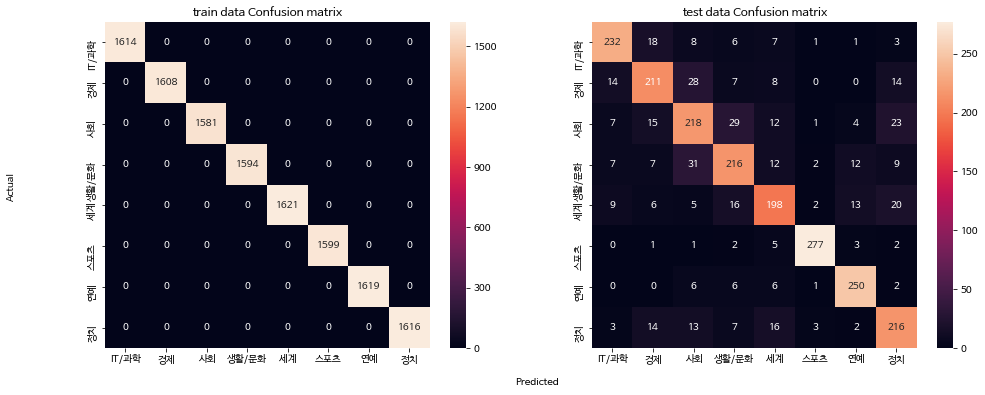

In [31]:
ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [32]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [33]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [34]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.9933
Accuracy: 0.8210


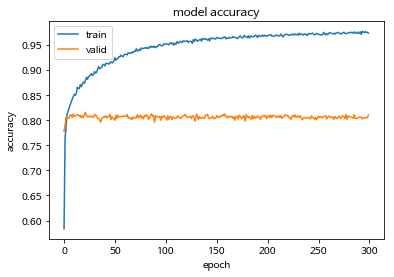

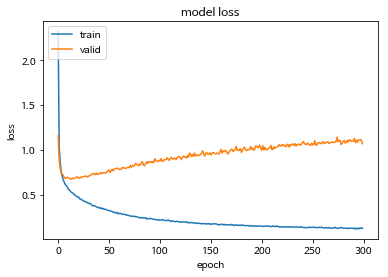

In [35]:
plot_history(history)

In [36]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [37]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 1.2171
Accuracy: 0.8157


In [38]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

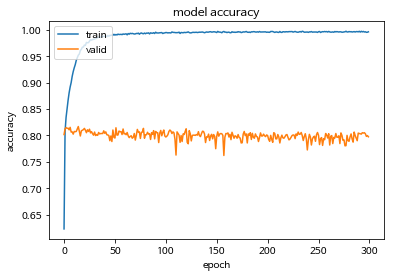

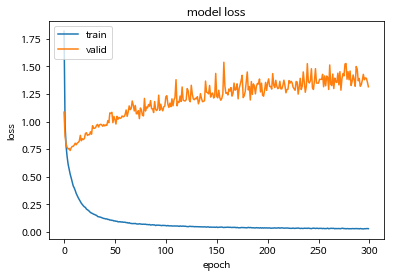

In [39]:
plot_history(history)

In [40]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

### model2

In [41]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-ct'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_ct_for_news_classification', 'rb'))
train_y2 = [y[0] for y in tqdm(train_y)]
len(train_y), len(train_x_by_m2)

100%|██████████| 12852/12852 [00:00<00:00, 1379143.30it/s]


(12852, 12852)

In [42]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-ct'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_ct_for_news_classification', 'rb'))
test_y2 = [y[0] for y in tqdm(test_y)]
len(test_y), len(test_x_by_m2)

100%|██████████| 2268/2268 [00:00<00:00, 1204594.34it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [43]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.6970899470899471
classification report
             precision    recall  f1-score   support

          0       0.85      0.79      0.82       276
          1       0.67      0.73      0.70       282
          2       0.63      0.64      0.63       309
          3       0.64      0.50      0.56       296
          4       0.61      0.62      0.62       269
          5       0.84      0.96      0.89       291
          6       0.74      0.66      0.70       271
          7       0.60      0.67      0.63       274

avg / total       0.70      0.70      0.69      2268

CPU times: user 25.4 s, sys: 161 ms, total: 25.5 s
Wall time: 25.6 s


In [44]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

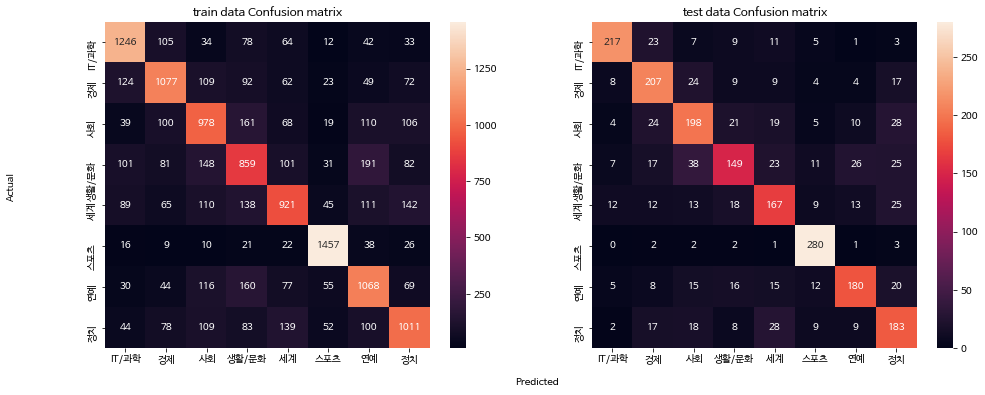

In [45]:
ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [46]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.6335978835978836
classification report
             precision    recall  f1-score   support

          0       0.73      0.78      0.76       276
          1       0.63      0.70      0.66       282
          2       0.58      0.64      0.61       309
          3       0.56      0.34      0.42       296
          4       0.56      0.59      0.57       269
          5       0.79      0.95      0.86       291
          6       0.64      0.49      0.56       271
          7       0.53      0.58      0.55       274

avg / total       0.63      0.63      0.62      2268

CPU times: user 45.1 s, sys: 269 ms, to

In [47]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

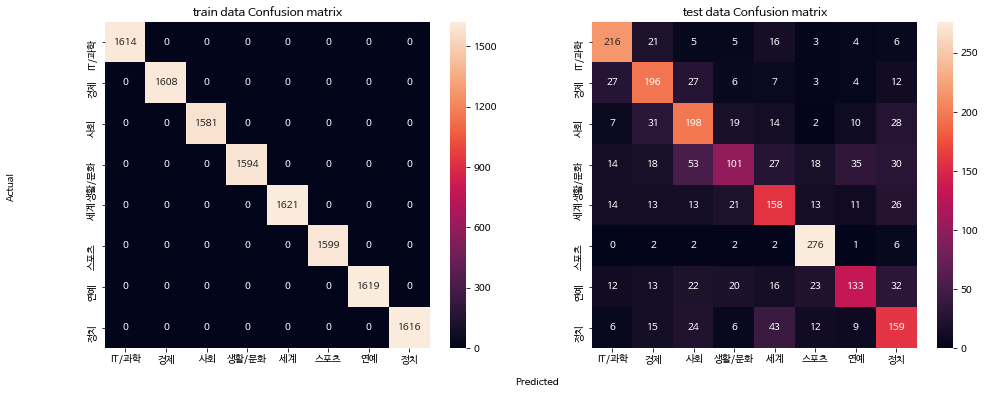

In [48]:
ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [49]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.6441798941798942
classification report
             precision    recall  f1-score   support

          0       0.80      0.76      0.78       276
          1       0.67      0.67      0.67       282
          2       0.55      0.65      0.60       309
          3       0.56      0.33      0.42       296
          4       0.61      0.58      0.60       269
          5       0.84      0.95      0.89       291
          6       0.63      0.58      0.60       271
          7       0.49      0.64      0.56       274

avg / total       0.64      0.64      0.64      2268

CPU times: user 2min 9s, sys: 327 ms, total: 2min 9s
Wall time: 2min 10s


In [50]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

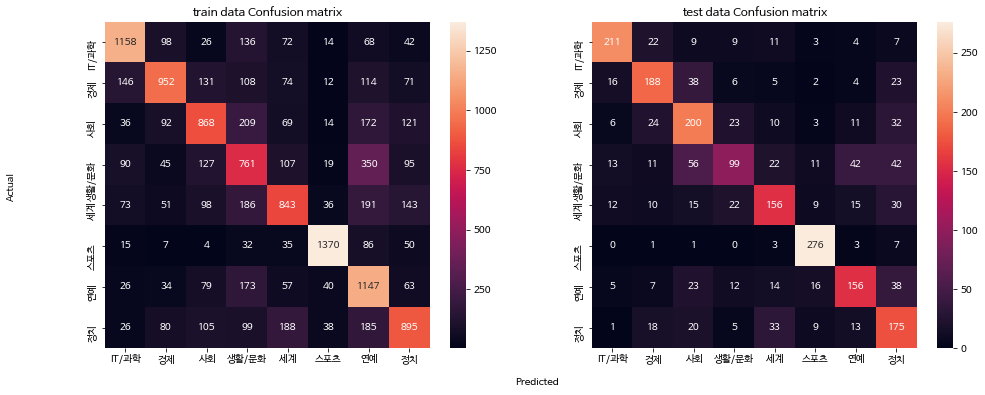

In [51]:
ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier3, le)

#### XGBoost 

In [52]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 664839.60it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 854534.81it/s]

CPU times: user 108 ms, sys: 29.4 ms, total: 137 ms
Wall time: 131 ms


In [53]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 27.5 ms, sys: 8.69 ms, total: 36.2 ms
Wall time: 32.9 ms


In [54]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m2_name)

[0]	train-mlogloss:1.92348	eval-mlogloss:1.91891
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.8001	eval-mlogloss:1.79477
[2]	train-mlogloss:1.69707	eval-mlogloss:1.69466
[3]	train-mlogloss:1.61003	eval-mlogloss:1.61256
[4]	train-mlogloss:1.53614	eval-mlogloss:1.54459
[5]	train-mlogloss:1.46905	eval-mlogloss:1.48432
[6]	train-mlogloss:1.40968	eval-mlogloss:1.43482
[7]	train-mlogloss:1.35631	eval-mlogloss:1.38926
[8]	train-mlogloss:1.30758	eval-mlogloss:1.34888
[9]	train-mlogloss:1.2624	eval-mlogloss:1.3125
[10]	train-mlogloss:1.22102	eval-mlogloss:1.27978
[11]	train-mlogloss:1.18316	eval-mlogloss:1.25094
[12]	train-mlogloss:1.14817	eval-mlogloss:1.22443
[13]	train-mlogloss:1.11584	eval-mlogloss:1.20239
[14]	train-mlogloss:1.0851	eval-mlogloss:1.18085
[15]	train-mlogloss:1.05593	eval-mlogloss:1.16194
[16]	train-mlogloss:1.02915	eval-mlogloss:1.14497
[17]	train-ml

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

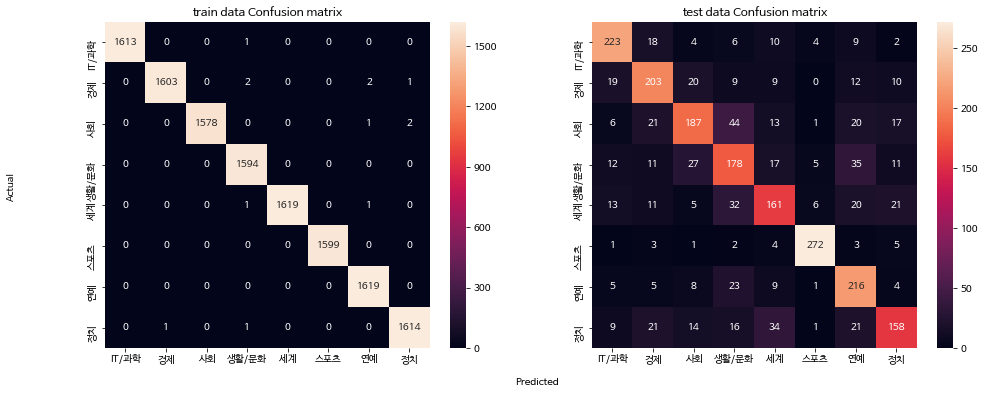

In [55]:
ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [56]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [57]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [58]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 1.1050
Accuracy: 0.7324


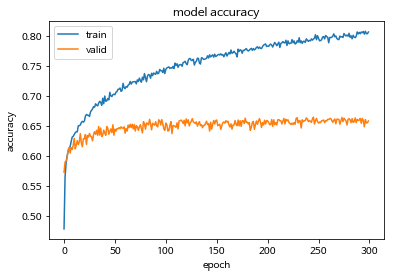

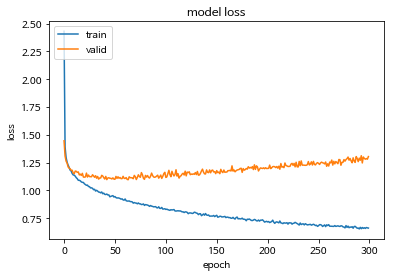

In [59]:
plot_history(history)

In [60]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [61]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 2.8932
Accuracy: 0.6601


In [62]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

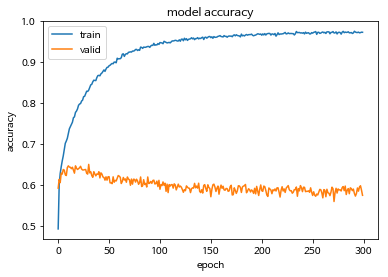

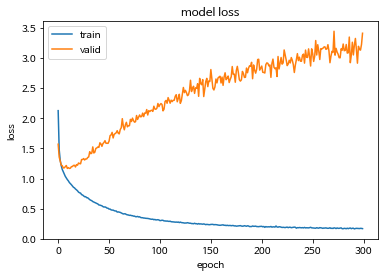

In [63]:
plot_history(history)

In [64]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

### model3

In [65]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-ct'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_ct_for_news_classification', 'rb'))
train_y2 = [y[0] for y in tqdm(train_y)]
len(train_y), len(train_x_by_m3)

100%|██████████| 12852/12852 [00:00<00:00, 1830707.93it/s]


(12852, 12852)

In [66]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-ct'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_ct_for_news_classification', 'rb'))
test_y2 = [y[0] for y in tqdm(test_y)]
len(test_y), len(test_x_by_m3)

100%|██████████| 2268/2268 [00:00<00:00, 1577297.54it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [67]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m3)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8747795414462081
classification report
             precision    recall  f1-score   support

          0       0.89      0.89      0.89       276
          1       0.82      0.85      0.83       282
          2       0.81      0.75      0.78       309
          3       0.83      0.83      0.83       296
          4       0.83      0.88      0.85       269
          5       0.98      0.98      0.98       291
          6       0.98      0.99      0.99       271
          7       0.85      0.85      0.85       274

avg / total       0.87      0.87      0.87      2268

CPU times: user 9.79 s, sys: 85.9 ms, total: 9.87 s
Wall time: 9.88 s


In [68]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

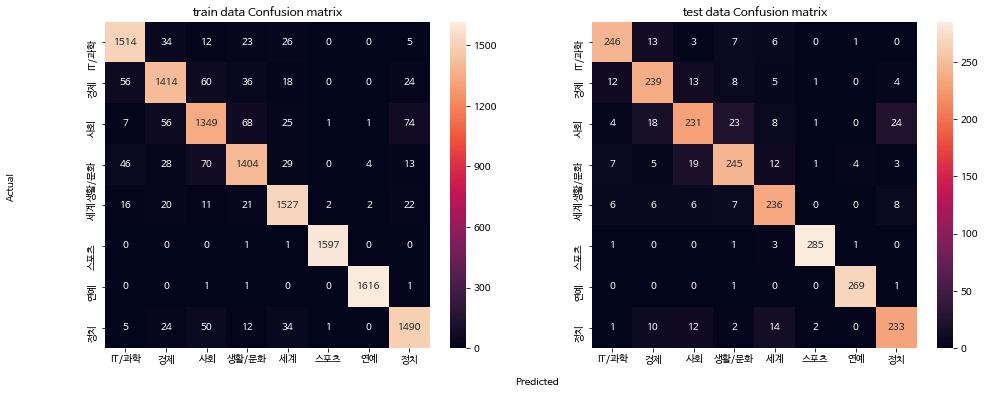

In [69]:
ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [70]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m3, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.7314814814814815
classification report
             precision    recall  f1-score   support

          0       0.71      0.81      0.76       276
          1       0.68      0.62      0.65       282
          2       0.69      0.59      0.63       309
          3       0.75      0.58      0.65       296
          4       0.69      0.72      0.71       269
          5       0.87      0.89      0.88       291
          6       0.77      0.98      0.86       271
          7       0.67      0.69      0.68       274

avg / total       0.73      0.73      0.73      2268

CPU times: user 41.7 s, sys: 253 ms, to

In [71]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

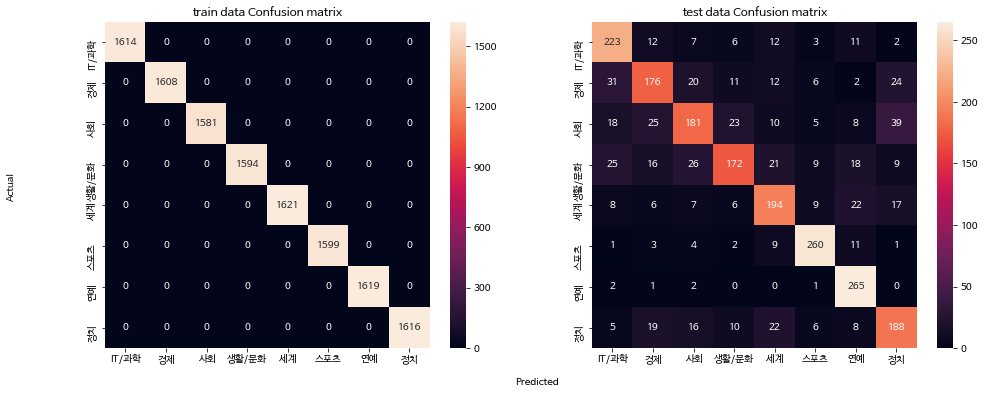

In [72]:
ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [73]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m3)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.8761022927689595
classification report
             precision    recall  f1-score   support

          0       0.88      0.91      0.90       276
          1       0.82      0.84      0.83       282
          2       0.80      0.74      0.77       309
          3       0.86      0.83      0.84       296
          4       0.85      0.90      0.87       269
          5       0.98      0.97      0.98       291
          6       0.96      0.99      0.97       271
          7       0.86      0.85      0.86       274

avg / total       0.88      0.88      0.88      2268

CPU times: user 1min 23s, sys: 176 ms, total: 1min 24s
Wall time: 1min 24s


In [74]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

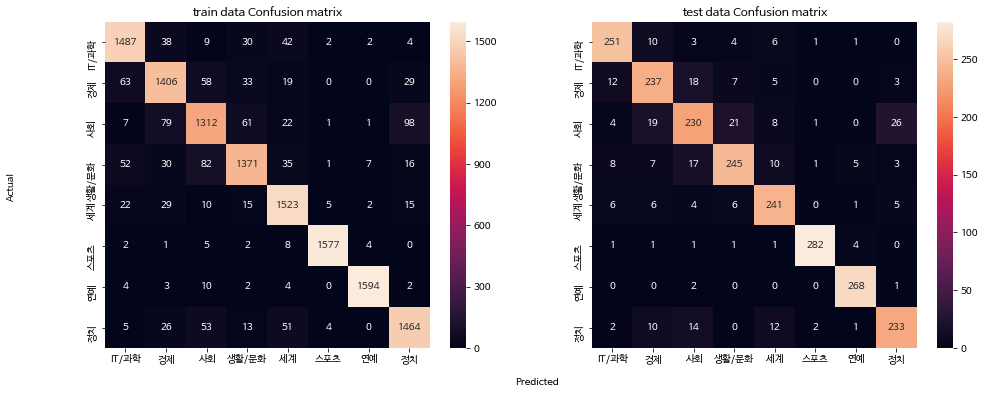

In [75]:
ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier3, le)

#### XGBoost 

In [76]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 697350.52it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 833860.58it/s]

CPU times: user 110 ms, sys: 30.8 ms, total: 141 ms
Wall time: 135 ms


In [77]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 28.3 ms, sys: 10.6 ms, total: 38.9 ms
Wall time: 36.1 ms


In [78]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m3_name)

[0]	train-mlogloss:1.94292	eval-mlogloss:1.97243
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.82298	eval-mlogloss:1.87567
[2]	train-mlogloss:1.72131	eval-mlogloss:1.79817
[3]	train-mlogloss:1.63086	eval-mlogloss:1.73022
[4]	train-mlogloss:1.54844	eval-mlogloss:1.66742
[5]	train-mlogloss:1.47397	eval-mlogloss:1.61083
[6]	train-mlogloss:1.4061	eval-mlogloss:1.55853
[7]	train-mlogloss:1.34356	eval-mlogloss:1.51245
[8]	train-mlogloss:1.28636	eval-mlogloss:1.4715
[9]	train-mlogloss:1.23385	eval-mlogloss:1.43443
[10]	train-mlogloss:1.18321	eval-mlogloss:1.39695
[11]	train-mlogloss:1.1358	eval-mlogloss:1.3604
[12]	train-mlogloss:1.09094	eval-mlogloss:1.32705
[13]	train-mlogloss:1.04865	eval-mlogloss:1.29624
[14]	train-mlogloss:1.00792	eval-mlogloss:1.2655
[15]	train-mlogloss:0.970421	eval-mlogloss:1.23932
[16]	train-mlogloss:0.934674	eval-mlogloss:1.21477
[17]	train-m

[156]	train-mlogloss:0.02442	eval-mlogloss:0.479756
[157]	train-mlogloss:0.023959	eval-mlogloss:0.479285
[158]	train-mlogloss:0.023491	eval-mlogloss:0.478516
[159]	train-mlogloss:0.023063	eval-mlogloss:0.477685
[160]	train-mlogloss:0.022608	eval-mlogloss:0.476932
[161]	train-mlogloss:0.022173	eval-mlogloss:0.476498
[162]	train-mlogloss:0.021718	eval-mlogloss:0.476176
[163]	train-mlogloss:0.021305	eval-mlogloss:0.475229
[164]	train-mlogloss:0.020925	eval-mlogloss:0.474968
[165]	train-mlogloss:0.020562	eval-mlogloss:0.474065
[166]	train-mlogloss:0.02019	eval-mlogloss:0.473163
[167]	train-mlogloss:0.019802	eval-mlogloss:0.47306
[168]	train-mlogloss:0.019421	eval-mlogloss:0.471953
[169]	train-mlogloss:0.019041	eval-mlogloss:0.471873
[170]	train-mlogloss:0.018729	eval-mlogloss:0.471263
[171]	train-mlogloss:0.018398	eval-mlogloss:0.471292
[172]	train-mlogloss:0.018065	eval-mlogloss:0.470566
[173]	train-mlogloss:0.017763	eval-mlogloss:0.470149
[174]	train-mlogloss:0.017476	eval-mlogloss:0.469

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

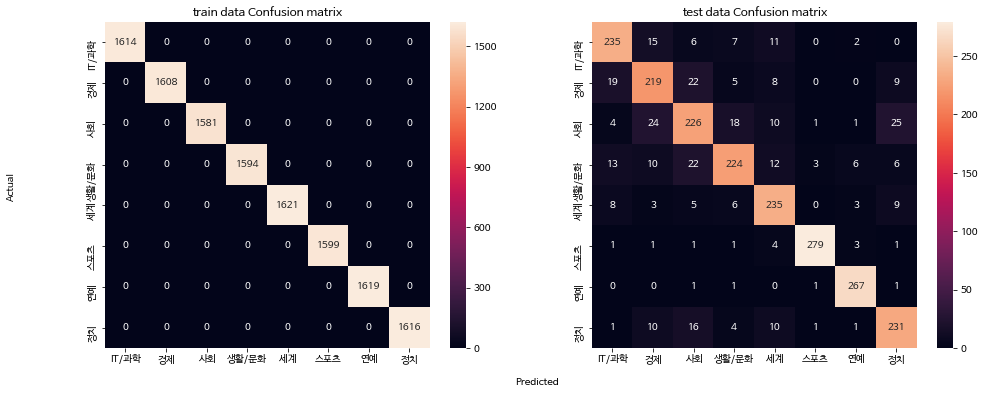

In [79]:
ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [80]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [81]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [82]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.7628
Accuracy: 0.8796


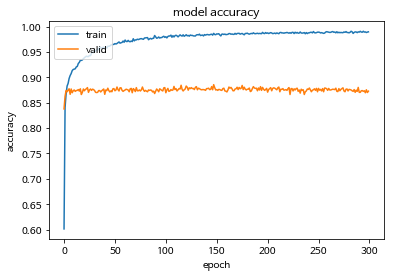

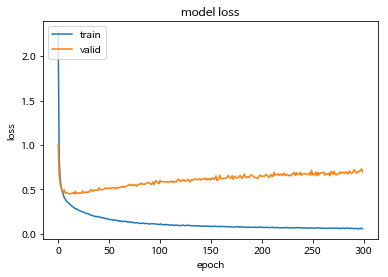

In [83]:
plot_history(history)

In [84]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

In [85]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.8911
Accuracy: 0.8787


In [86]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

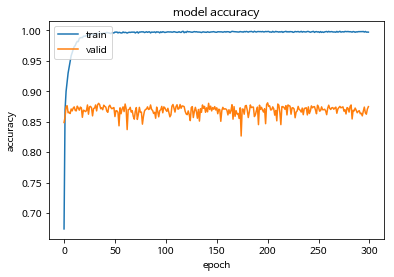

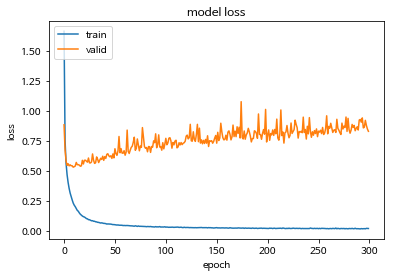

In [87]:
plot_history(history)

In [88]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name

### Mecab

### Load Model

In [89]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model')

### Train dataset & test dataset

In [90]:
trainName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_train_for_news_classification_by_mecab.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_test_for_news_classification_by_mecab.pickled'

In [91]:
train = pickle.load(open(trainName, 'rb'))
test = pickle.load(open(testName, 'rb'))

#### train dataset

In [92]:
taggerName = 'mecab'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_category_y_mecab_for_news_classification'):
    train_category_y = [doc.category for doc in tqdm(train)]
    
    pickle.dump(train_category_y, open(saveTrainPath+'train_category_y_mecab_for_news_classification','wb'))
    del train_category_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_mecab_for_news_classification'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_mecab_for_news_classification','wb'))
    del train_tags_y

if 'train' in locals():
    del train

#### test dataset

In [93]:
taggerName = 'mecab'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_category_y_mecab_for_news_classification'):
    test_category_y = [doc.category for doc in tqdm(test)]
    
    pickle.dump(test_category_y, open(saveTrainPath+'test_category_y_mecab_for_news_classification','wb'))
    del test_category_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_mecab_for_news_classification'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_mecab_for_news_classification','wb'))
    del test_tags_y

if 'test' in locals():
    del test

### model1

In [94]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-mecab'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_mecab_for_news_classification', 'rb'))
train_y2 = [y[0] for y in tqdm(train_y)]
len(train_y), len(train_x_by_m1)

100%|██████████| 12852/12852 [00:00<00:00, 1378085.57it/s]


(12852, 12852)

In [95]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_mecab_for_news_classification', 'rb'))
test_y2 = [y[0] for y in tqdm(test_y)]
len(test_y), len(test_x_by_m1)

100%|██████████| 2268/2268 [00:00<00:00, 1470502.62it/s]


(2268, 2268)

In [96]:
set(test_y2)

{0, 1, 2, 3, 4, 5, 6, 7}

In [97]:
train_x_by_m1[1]

array([ 1.82082605e+00,  2.49800861e-01,  4.57608044e-01, -5.36249280e-01,
       -1.08399630e+00, -1.69356093e-01,  4.33509827e-01,  2.29123920e-01,
        1.47551760e-01, -6.75153852e-01, -2.22434521e-01, -4.62914377e-01,
       -8.97507146e-02, -6.91307366e-01,  5.83308518e-01, -1.24048352e+00,
        7.19061553e-01,  1.00132596e+00,  5.72236329e-02, -5.13041198e-01,
       -1.95609689e-01, -1.05434799e+00, -5.13985872e-01,  8.22789073e-02,
        1.00287652e+00, -1.77355602e-01,  7.42321789e-01,  1.29856020e-01,
       -3.73879969e-01, -2.72660643e-01, -8.49539489e-02, -6.89262033e-01,
       -8.25472325e-02, -5.27637780e-01,  8.62296000e-02, -5.41226268e-01,
       -5.24247229e-01, -1.58323228e-01,  9.21792686e-01, -3.74456197e-01,
       -1.10872746e+00,  8.01912904e-01,  7.87061095e-01, -6.55620456e-01,
       -4.54514265e-01, -5.35223544e-01, -1.03468977e-01,  2.95042217e-01,
       -7.32802629e-01, -2.70030331e-02,  7.39368975e-01, -7.86269188e-01,
        2.79990464e-01, -

#### 분류모델 : Logistic Regression

In [98]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.140652557319224
classification report
             precision    recall  f1-score   support

          0       0.12      0.16      0.14       274
          1       0.12      0.02      0.03       312
          2       0.19      0.06      0.09       277
          3       0.15      0.06      0.08       266
          4       0.14      0.10      0.12       296
          5       0.13      0.39      0.19       285
          6       0.17      0.22      0.19       283
          7       0.16      0.12      0.14       275

avg / total       0.15      0.14      0.12      2268

CPU times: user 16 s, sys: 113 ms, total: 16.1 s
Wall time: 16.2 s


In [99]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

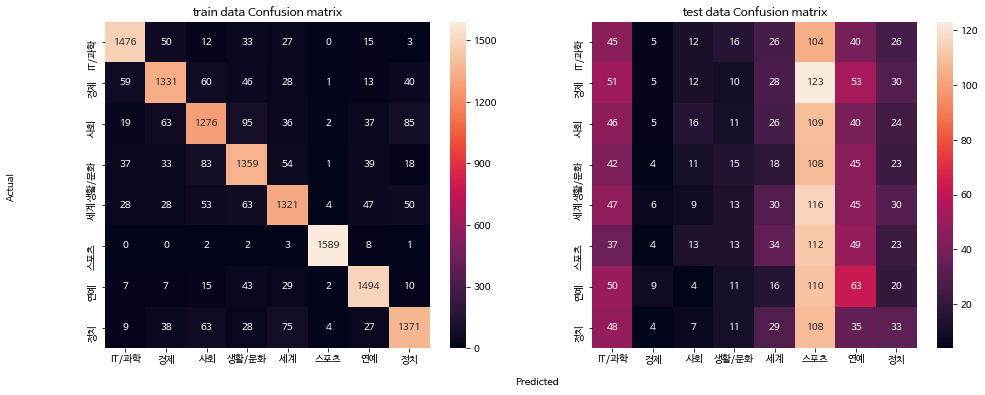

In [100]:
ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [101]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.12654320987654322
classification report
             precision    recall  f1-score   support

          0       0.13      0.12      0.12       274
          1       0.11      0.07      0.08       312
          2       0.11      0.19      0.14       277
          3       0.12      0.13      0.12       266
          4       0.15      0.20      0.17       296
          5       0.13      0.14      0.13       285
          6       0.15      0.12      0.13       283
          7       0.11      0.05      0.07       275

avg / total       0.13      0.13      0.12      2268

CPU times: user 43.3 s, sys: 252 ms, t

In [102]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

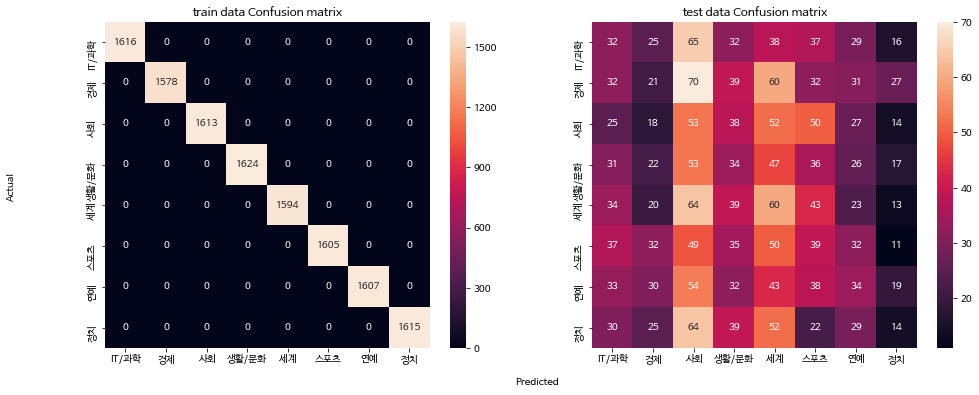

In [103]:
ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [104]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1)))

[LibSVM]

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.13271604938271606
classification report
             precision    recall  f1-score   support

          0       0.14      0.05      0.08       274
          1       0.04      0.00      0.01       312
          2       0.13      0.33      0.18       277
          3       0.11      0.12      0.12       266
          4       0.14      0.16      0.14       296
          5       0.13      0.16      0.14       285
          6       0.16      0.22      0.19       283
          7       0.18      0.02      0.04       275

avg / total       0.13      0.13      0.11      2268

CPU times: user 1min 19s, sys: 228 ms, total: 1min 19s
Wall time: 1min 19s


In [105]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

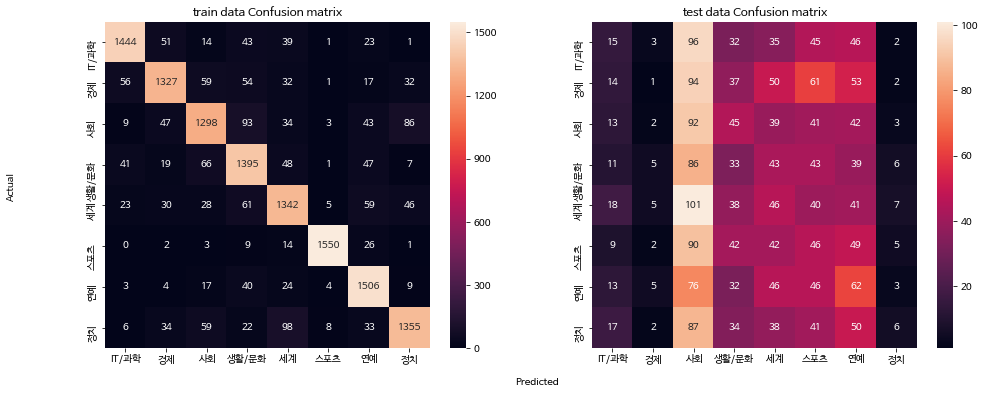

In [106]:
ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier3, le)

#### XGBoost 

In [107]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 701616.49it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 831382.75it/s]

CPU times: user 104 ms, sys: 21.4 ms, total: 126 ms
Wall time: 121 ms


In [108]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 25.3 ms, sys: 5.98 ms, total: 31.3 ms
Wall time: 28.4 ms


In [109]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m1_name)

[0]	train-mlogloss:1.92197	eval-mlogloss:2.08689
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.79883	eval-mlogloss:2.09269
[2]	train-mlogloss:1.69155	eval-mlogloss:2.10134
[3]	train-mlogloss:1.59703	eval-mlogloss:2.10894
[4]	train-mlogloss:1.51421	eval-mlogloss:2.1169
[5]	train-mlogloss:1.43793	eval-mlogloss:2.12589
[6]	train-mlogloss:1.36991	eval-mlogloss:2.13512
[7]	train-mlogloss:1.30812	eval-mlogloss:2.14549
[8]	train-mlogloss:1.24967	eval-mlogloss:2.15483
[9]	train-mlogloss:1.19636	eval-mlogloss:2.16453
[10]	train-mlogloss:1.1459	eval-mlogloss:2.17072
Stopping. Best iteration:
[0]	train-mlogloss:1.92197	eval-mlogloss:2.08689

0.12610229276895943
CPU times: user 1min 3s, sys: 322 ms, total: 1min 4s
Wall time: 18.8 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

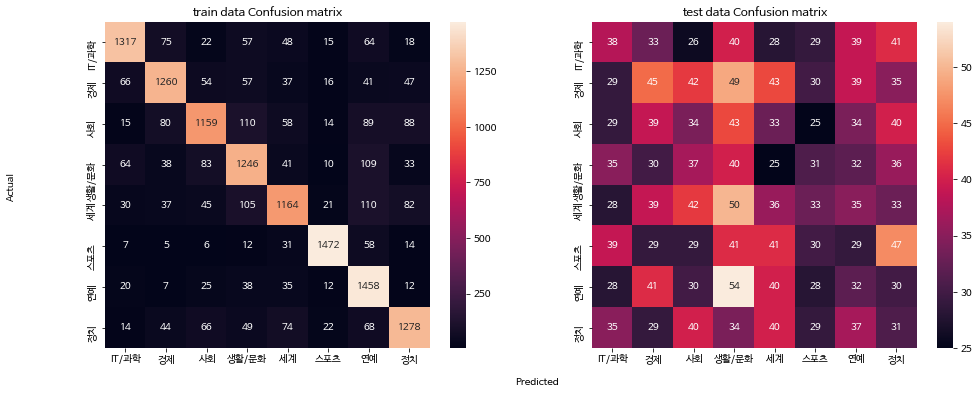

In [110]:
ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [111]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [112]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [113]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 7.4802
Accuracy: 0.1407


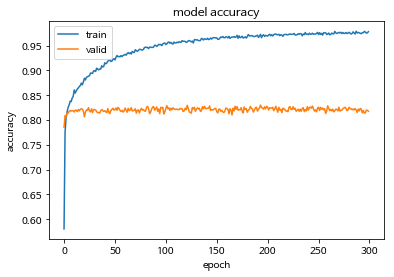

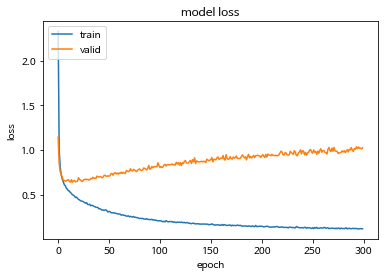

In [114]:
plot_history(history)

In [115]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [116]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 8.2272
Accuracy: 0.1358


In [117]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

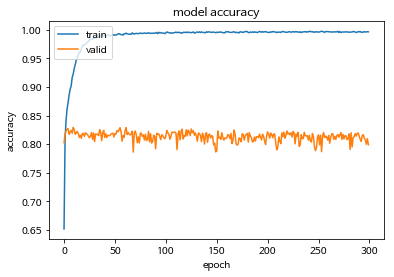

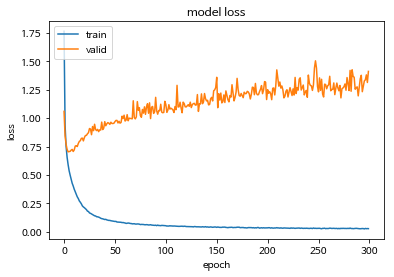

In [118]:
plot_history(history)

In [119]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

### model2

In [120]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-mecab'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_mecab_for_news_classification', 'rb'))
train_y2 = [y[0] for y in tqdm(train_y)]
len(train_y), len(train_x_by_m2)

100%|██████████| 12852/12852 [00:00<00:00, 1847396.93it/s]


(12852, 12852)

In [121]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-mecab'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_mecab_for_news_classification', 'rb'))
test_y2 = [y[0] for y in tqdm(test_y)]
len(test_y), len(test_x_by_m2)

100%|██████████| 2268/2268 [00:00<00:00, 1250188.13it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [122]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.6798941798941799
classification report
             precision    recall  f1-score   support

          0       0.77      0.69      0.73       274
          1       0.67      0.65      0.66       312
          2       0.58      0.65      0.62       277
          3       0.59      0.48      0.53       266
          4       0.62      0.62      0.62       296
          5       0.86      0.92      0.89       285
          6       0.71      0.75      0.73       283
          7       0.63      0.67      0.65       275

avg / total       0.68      0.68      0.68      2268

CPU times: user 26.6 s, sys: 107 ms, total: 26.7 s
Wall time: 26.7 s


In [123]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

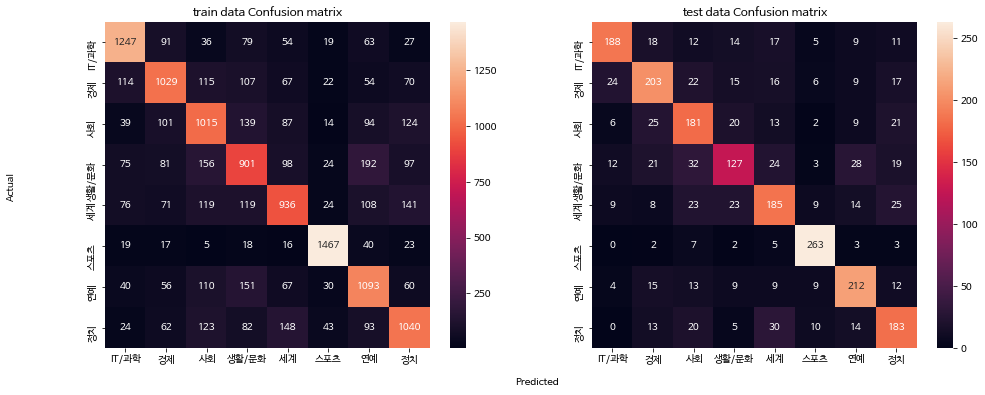

In [124]:
ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [125]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.6428571428571429
classification report
             precision    recall  f1-score   support

          0       0.70      0.69      0.70       274
          1       0.66      0.56      0.61       312
          2       0.55      0.69      0.61       277
          3       0.58      0.44      0.50       266
          4       0.56      0.56      0.56       296
          5       0.84      0.92      0.88       285
          6       0.65      0.65      0.65       283
          7       0.59      0.63      0.61       275

avg / total       0.64      0.64      0.64      2268

CPU times: user 44.9 s, sys: 242 ms, to

In [126]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

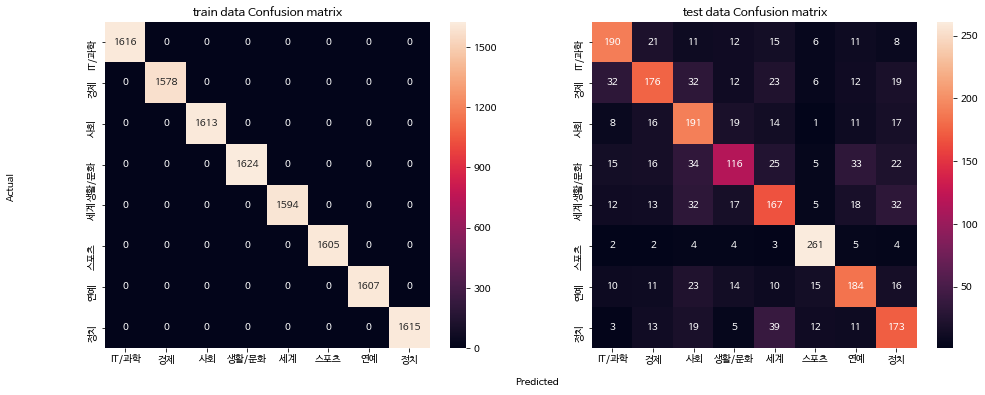

In [127]:
ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [128]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.6516754850088183
classification report
             precision    recall  f1-score   support

          0       0.78      0.69      0.73       274
          1       0.67      0.64      0.66       312
          2       0.57      0.68      0.62       277
          3       0.55      0.39      0.46       266
          4       0.59      0.57      0.58       296
          5       0.85      0.87      0.86       285
          6       0.61      0.72      0.66       283
          7       0.59      0.65      0.62       275

avg / total       0.65      0.65      0.65      2268

CPU times: user 2min 6s, sys: 407 ms, total: 2min 6s
Wall time: 2min 6s


In [129]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

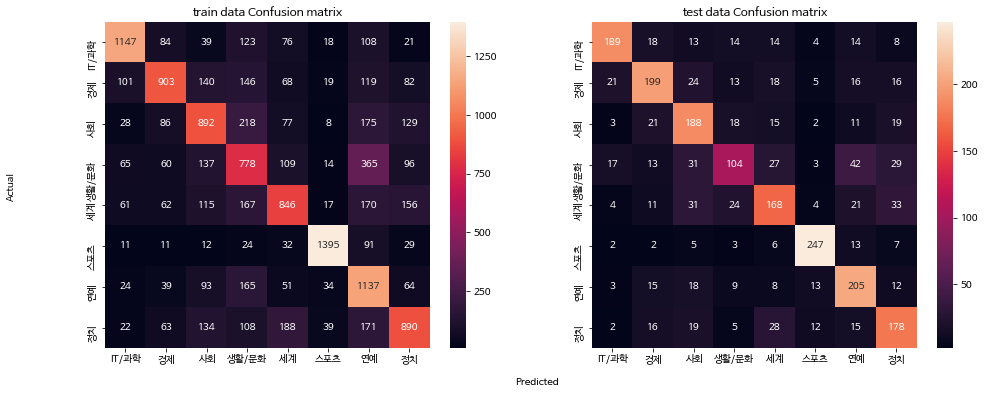

In [130]:
ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier3, le)

#### XGBoost 

In [131]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 769953.22it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 890533.75it/s]

CPU times: user 108 ms, sys: 29.3 ms, total: 137 ms
Wall time: 133 ms


In [132]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 26.5 ms, sys: 8.77 ms, total: 35.3 ms
Wall time: 32.7 ms


In [133]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m2_name)

[0]	train-mlogloss:1.9184	eval-mlogloss:1.92145
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.79647	eval-mlogloss:1.80452
[2]	train-mlogloss:1.69565	eval-mlogloss:1.71276
[3]	train-mlogloss:1.60996	eval-mlogloss:1.63749
[4]	train-mlogloss:1.53555	eval-mlogloss:1.57493
[5]	train-mlogloss:1.46819	eval-mlogloss:1.51722
[6]	train-mlogloss:1.40996	eval-mlogloss:1.46809
[7]	train-mlogloss:1.35673	eval-mlogloss:1.426
[8]	train-mlogloss:1.30925	eval-mlogloss:1.38907
[9]	train-mlogloss:1.26498	eval-mlogloss:1.35442
[10]	train-mlogloss:1.22553	eval-mlogloss:1.32314
[11]	train-mlogloss:1.18686	eval-mlogloss:1.29573
[12]	train-mlogloss:1.15148	eval-mlogloss:1.27154
[13]	train-mlogloss:1.11958	eval-mlogloss:1.25071
[14]	train-mlogloss:1.08873	eval-mlogloss:1.22833
[15]	train-mlogloss:1.05918	eval-mlogloss:1.20871
[16]	train-mlogloss:1.03138	eval-mlogloss:1.19175
[17]	train-m

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

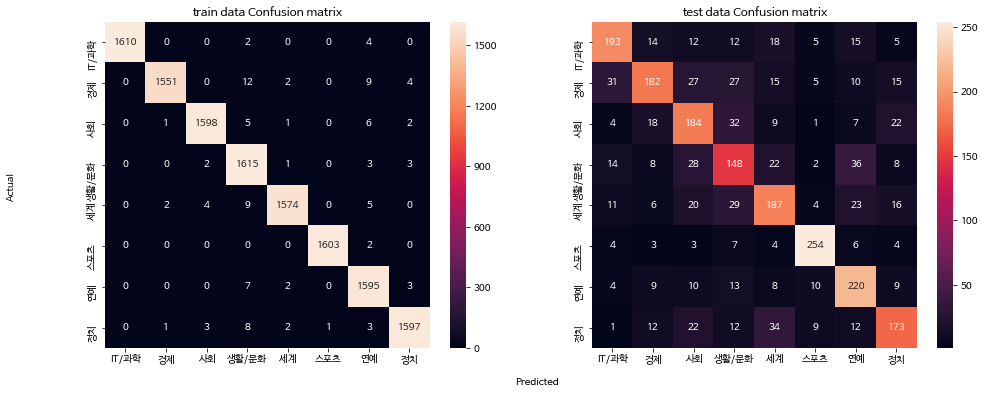

In [134]:
ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [135]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [136]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [137]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 1.1499
Accuracy: 0.6962


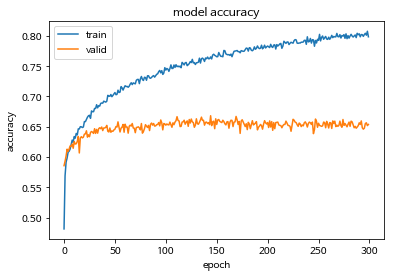

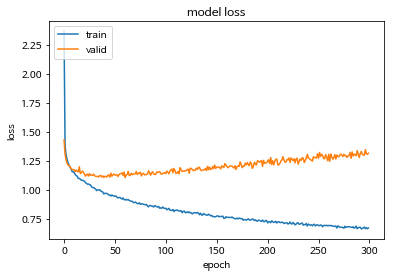

In [138]:
plot_history(history)

In [139]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [140]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 2.9355
Accuracy: 0.6332


In [141]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

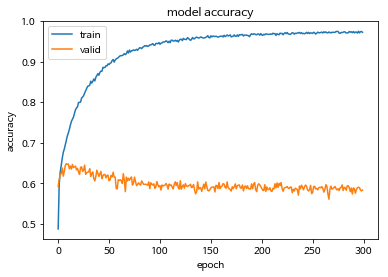

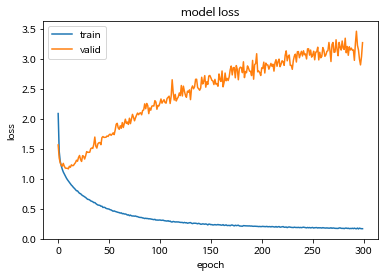

In [142]:
plot_history(history)

In [143]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

### model3

In [144]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-mecab'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_mecab_for_news_classification', 'rb'))
train_y2 = [y[0] for y in tqdm(train_y)]
len(train_y), len(train_x_by_m3)

100%|██████████| 12852/12852 [00:00<00:00, 1740505.47it/s]


(12852, 12852)

In [145]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-mecab'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_mecab_for_news_classification', 'rb'))
test_y2 = [y[0] for y in tqdm(test_y)]
len(test_y), len(test_x_by_m3)

100%|██████████| 2268/2268 [00:00<00:00, 1616428.46it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [146]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m3)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8747795414462081
classification report
             precision    recall  f1-score   support

          0       0.86      0.87      0.86       274
          1       0.84      0.80      0.82       312
          2       0.80      0.76      0.78       277
          3       0.84      0.81      0.82       266
          4       0.85      0.88      0.86       296
          5       0.99      0.98      0.98       285
          6       0.95      1.00      0.97       283
          7       0.87      0.90      0.88       275

avg / total       0.87      0.87      0.87      2268

CPU times: user 10.1 s, sys: 66.6 ms, total: 10.1 s
Wall time: 10.1 s


In [147]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

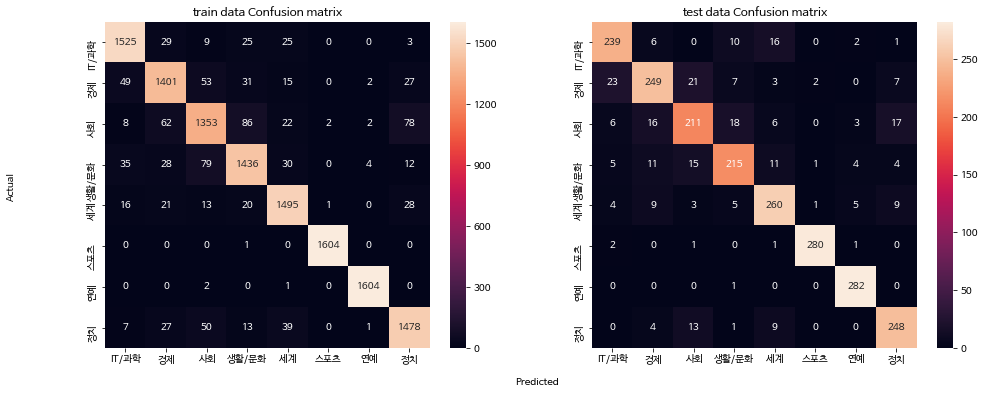

In [148]:
ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [149]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m3, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.7508818342151675
classification report
             precision    recall  f1-score   support

          0       0.72      0.82      0.77       274
          1       0.73      0.71      0.72       312
          2       0.64      0.58      0.61       277
          3       0.81      0.59      0.69       266
          4       0.68      0.72      0.70       296
          5       0.89      0.89      0.89       285
          6       0.82      0.95      0.88       283
          7       0.72      0.73      0.73       275

avg / total       0.75      0.75      0.75      2268

CPU times: user 41.9 s, sys: 246 ms, to

In [150]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

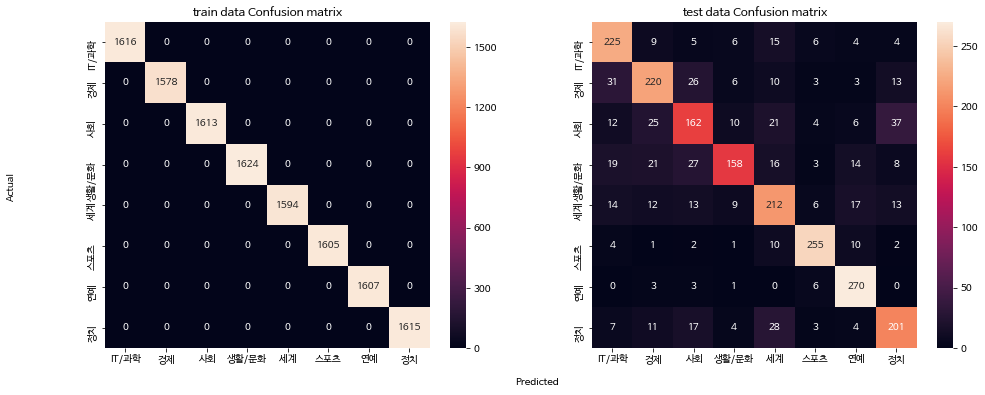

In [151]:
ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [152]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m3)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.8893298059964727
classification report
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       274
          1       0.86      0.82      0.84       312
          2       0.82      0.75      0.78       277
          3       0.85      0.83      0.84       266
          4       0.85      0.92      0.88       296
          5       1.00      0.98      0.99       285
          6       0.98      1.00      0.99       283
          7       0.86      0.92      0.89       275

avg / total       0.89      0.89      0.89      2268

CPU times: user 1min 23s, sys: 188 ms, total: 1min 23s
Wall time: 1min 23s


In [153]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

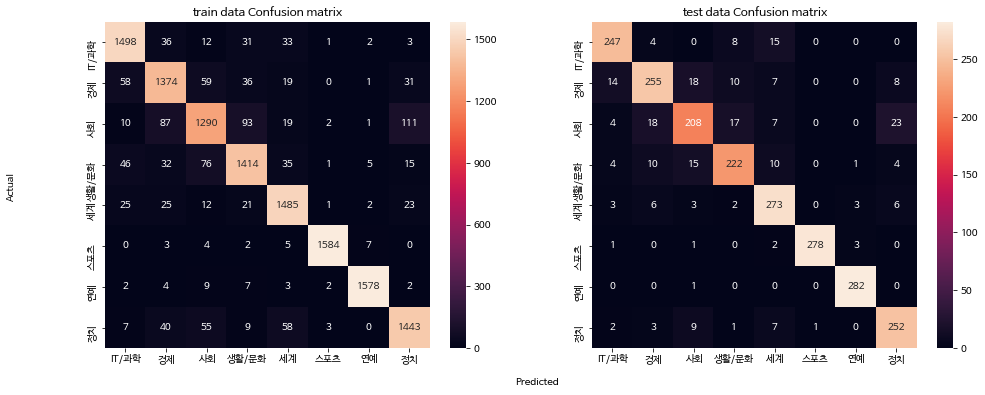

In [154]:
ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier3, le)

#### XGBoost 

In [155]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 587567.39it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 852925.80it/s]

CPU times: user 111 ms, sys: 31.9 ms, total: 143 ms
Wall time: 137 ms


In [156]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 28.7 ms, sys: 11.4 ms, total: 40.2 ms
Wall time: 36.9 ms


In [157]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m3_name)

[0]	train-mlogloss:1.93218	eval-mlogloss:1.95528
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.8132	eval-mlogloss:1.86117
[2]	train-mlogloss:1.70494	eval-mlogloss:1.77809
[3]	train-mlogloss:1.61139	eval-mlogloss:1.70427
[4]	train-mlogloss:1.52974	eval-mlogloss:1.64121
[5]	train-mlogloss:1.45162	eval-mlogloss:1.58253
[6]	train-mlogloss:1.38193	eval-mlogloss:1.52909
[7]	train-mlogloss:1.31868	eval-mlogloss:1.47958
[8]	train-mlogloss:1.26074	eval-mlogloss:1.43587
[9]	train-mlogloss:1.20503	eval-mlogloss:1.39278
[10]	train-mlogloss:1.15324	eval-mlogloss:1.35073
[11]	train-mlogloss:1.1056	eval-mlogloss:1.31445
[12]	train-mlogloss:1.06167	eval-mlogloss:1.28099
[13]	train-mlogloss:1.01971	eval-mlogloss:1.25045
[14]	train-mlogloss:0.978979	eval-mlogloss:1.2191
[15]	train-mlogloss:0.941468	eval-mlogloss:1.19198
[16]	train-mlogloss:0.907123	eval-mlogloss:1.16551
[17]	trai

[156]	train-mlogloss:0.023217	eval-mlogloss:0.440662
[157]	train-mlogloss:0.02274	eval-mlogloss:0.43958
[158]	train-mlogloss:0.022297	eval-mlogloss:0.43925
[159]	train-mlogloss:0.021843	eval-mlogloss:0.439023
[160]	train-mlogloss:0.021471	eval-mlogloss:0.437545
[161]	train-mlogloss:0.021086	eval-mlogloss:0.436689
[162]	train-mlogloss:0.020722	eval-mlogloss:0.436313
[163]	train-mlogloss:0.020349	eval-mlogloss:0.434898
[164]	train-mlogloss:0.01998	eval-mlogloss:0.433583
[165]	train-mlogloss:0.019607	eval-mlogloss:0.432819
[166]	train-mlogloss:0.01923	eval-mlogloss:0.431806
[167]	train-mlogloss:0.018866	eval-mlogloss:0.430893
[168]	train-mlogloss:0.018526	eval-mlogloss:0.430019
[169]	train-mlogloss:0.018203	eval-mlogloss:0.428922
[170]	train-mlogloss:0.017897	eval-mlogloss:0.428666
[171]	train-mlogloss:0.017582	eval-mlogloss:0.428449
[172]	train-mlogloss:0.017283	eval-mlogloss:0.428179
[173]	train-mlogloss:0.016975	eval-mlogloss:0.42786
[174]	train-mlogloss:0.01667	eval-mlogloss:0.427191


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

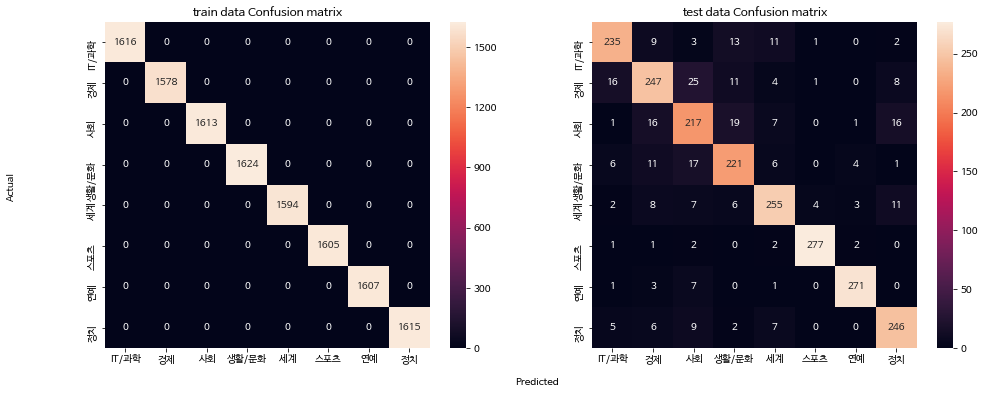

In [158]:
ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [159]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [160]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [161]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.7025
Accuracy: 0.8854


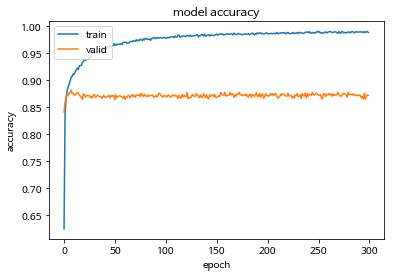

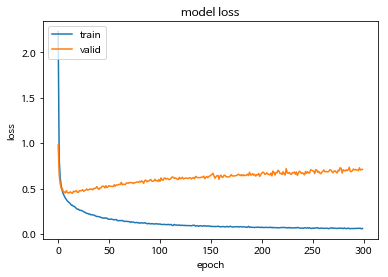

In [162]:
plot_history(history)

In [163]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

In [164]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.9465
Accuracy: 0.8805


In [165]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

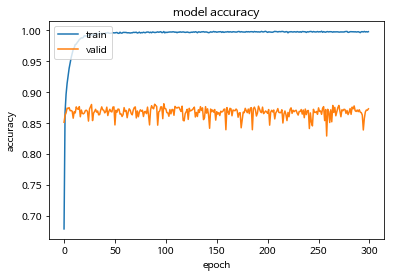

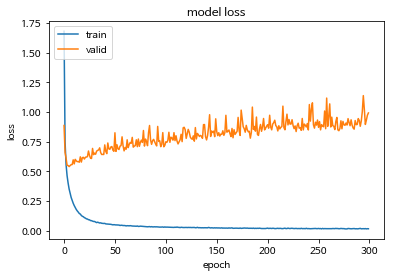

In [166]:
plot_history(history)

In [167]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name